In [2]:
#checking the PyTorch version
import torch
print(torch.__version__)

2.2.2+cu121


In [9]:
#installing required uninstalled libraries
!pip install -q transformers 

In [10]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#importing all libraries

from transformers import pipeline
from transformers import AutoModel
from transformers import ViTFeatureExtractor, ViTModel
import torch
from datasets import load_dataset
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from datasets import load_metric
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [ ]:
Hugging Face Dataset: Datasets: sasha/dog-food 

In [14]:
# If importing dataset with pandas
'''import pandas as pd

splits = {'train': 'data/train-00000-of-00001-9bf5abf8b080cbba.parquet', 'test': 'data/test-00000-of-00001-6ea6ccdcc8fa38d5.parquet'}
df = pd.read_parquet("hf://datasets/sasha/dog-food/" + splits["train"])'''

In [5]:
#If importing the dataset with Datasets
from datasets import load_dataset

ds = load_dataset("sasha/dog-food")

In [6]:
#inspecting the details of dataset
print(ds.shape)
print(ds['train'])

{'train': (2100, 2), 'test': (900, 2)}
Dataset({
    features: ['image', 'label'],
    num_rows: 2100
})


In [7]:
# storing training and test datasets separately
train_ds = ds['train']
print(train_ds.shape)
print(train_ds[:2])
test_ds = ds['test']
print(test_ds.shape)
print(test_ds[:2])

(2100, 2)
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x470 at 0x76A1EC292FB0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=408x612 at 0x76A1EC1085B0>], 'label': [0, 0]}
(900, 2)
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1600x1200 at 0x76A1EC2921A0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x408 at 0x76A1EC108580>], 'label': [0, 0]}


In [8]:
# split up training dataset into training + validation datasets
splits = train_ds.train_test_split(test_size=0.15)
train_ds = splits['train']
val_ds = splits['test']


In [9]:
#size of datasets
print(train_ds.shape)
print(val_ds.shape)
print(test_ds.shape)

(1785, 2)
(315, 2)
(900, 2)


In [17]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 1785
})

In [10]:
#checking the features
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['dog', 'food'], id=None)}

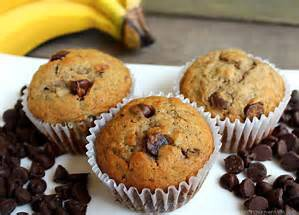

In [11]:
train_ds[150]['image']

In [12]:
print(train_ds[150]['label'])

1


In [13]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'dog', 1: 'food'}

In [ ]:
Pre-processing Data

In [14]:
from transformers import ViTImageProcessor
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [15]:
print(feature_extractor.size)
size = (feature_extractor.size['height'], feature_extractor.size['width'])
print(size)

{'height': 224, 'width': 224}
(224, 224)


In [16]:
#Data Augmentation
'''CenterCrop - Crops the given image at the center.
Compose - Composes several transforms together.
Normalize - Normalize a tensor image with mean and standard deviation.
RandomHorizontalFlip - Horizontally flip the given image randomly with a given probability.
RandomResizedCrop - Crop a random portion of image and resize it to a given size.
Resize - Resize the input image to the given size.
ToTensor - Convert a PIL Image or numpy.ndarray to tensor.'''

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    RandomRotation,
                                    ToTensor)
#we have taken here mean for normalization we can also take standard deviation
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(0.10),
            RandomVerticalFlip(0.10),
            RandomRotation(5),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

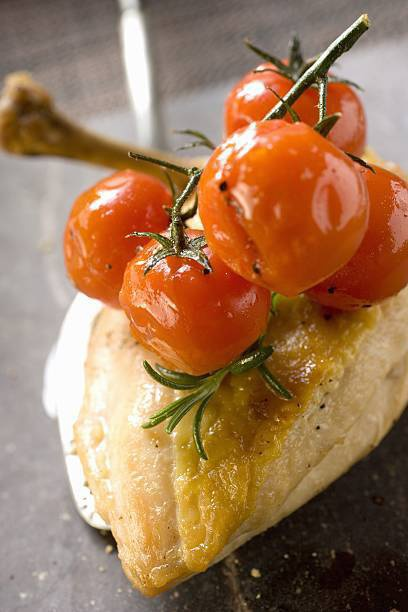

In [17]:
train_ds[6]['image']

In [18]:
print(train_ds[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=236x254 at 0x76A1EC109E10>, 'label': 0}


In [28]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)
print(train_ds[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=236x254 at 0x76A1DC7C3DC0>, 'label': 0, 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1.

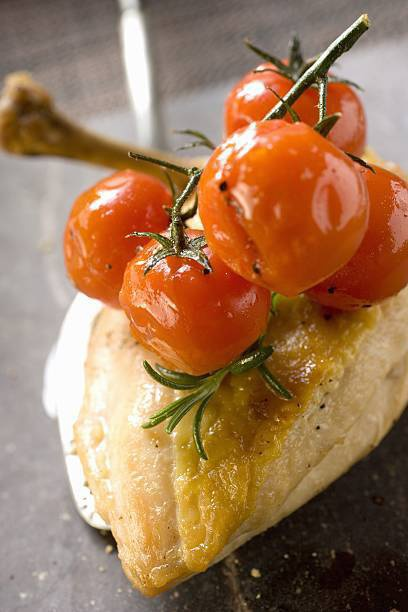

In [29]:
train_ds[6]['image']

In [30]:
#load preprocessed images
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [31]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    #print(f'k:{k}')
    #print(F'v:{v}')
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [32]:
# Defining the Model
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',num_labels=2,id2label= id2label,label2id= label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-image",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [34]:
# Evaluation to be done at the end of each epoch

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [35]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor
)

In [ ]:
Training the Model

In [36]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.033048,0.996825
2,No log,0.023487,0.996825


TrainOutput(global_step=358, training_loss=0.09773824468005303, metrics={'train_runtime': 106.8789, 'train_samples_per_second': 33.402, 'train_steps_per_second': 3.35, 'total_flos': 2.7664640292409344e+17, 'train_loss': 0.09773824468005303, 'epoch': 2.0})

In [37]:
outputs = trainer.predict(test_ds)

In [38]:
print(outputs.metrics)

{'test_loss': 0.029500532895326614, 'test_accuracy': 1.0, 'test_runtime': 11.966, 'test_samples_per_second': 75.213, 'test_steps_per_second': 18.803}


In [ ]:
Evaluation: With Confusion Matrix

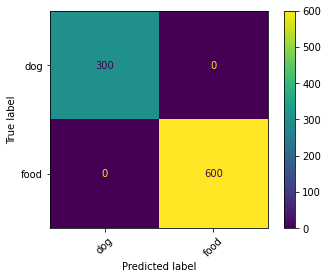

In [39]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)